# Változó számának csökkentése, változó kiválasztás

## F1/a - normál eloszlású változók generálása

In [1]:
import pandas as pd
import numpy as np

In [2]:
def get_random_df(nrow, ncol):
    np.random.seed(42)
    random_dict = {}

    for i in range(ncol):
        random_dict[f'random_{i}'] = np.random.normal(0, 1, nrow)

    random_df = pd.DataFrame(random_dict)
    random_df['label'] = random_df.index % 2
    return random_df

In [3]:
random_df = get_random_df(2000, 1000)

## F1/b - Dimenziók átkának demonstrációja

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score

In [5]:
X_train, X_test, y_train, y_test = train_test_split(random_df.drop('label', axis=1), random_df['label'], test_size=0.2, random_state=42)

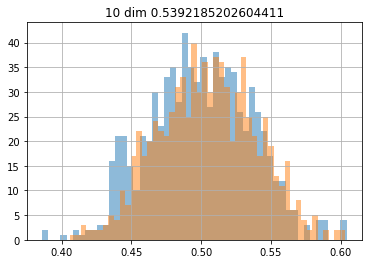

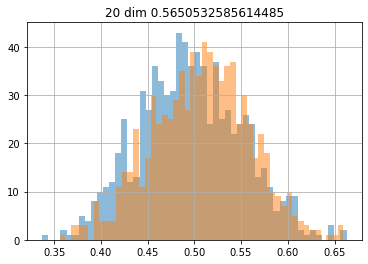

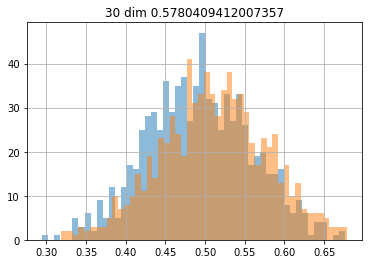

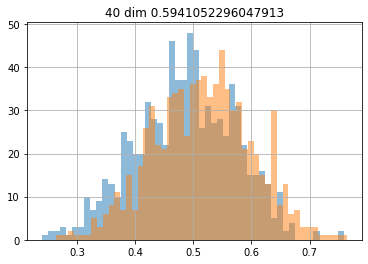

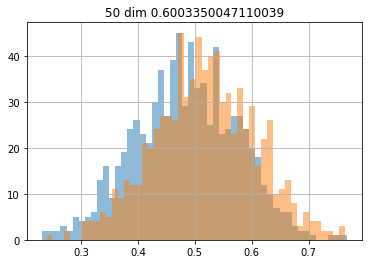

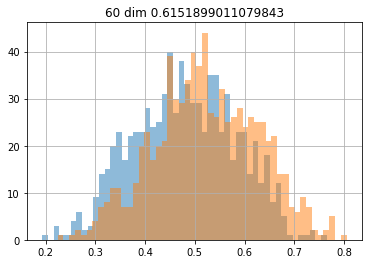

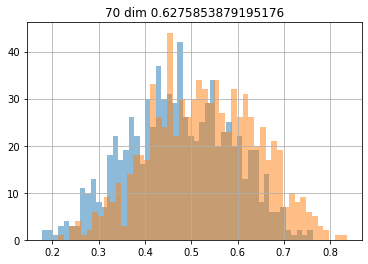

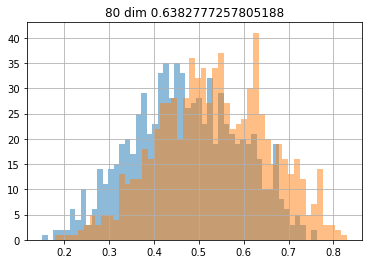

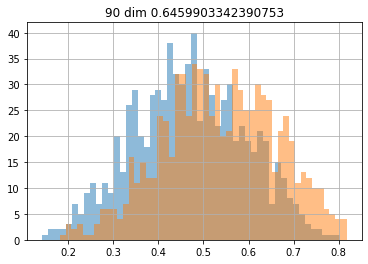

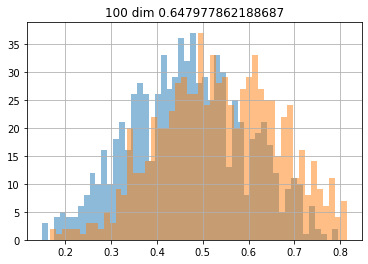

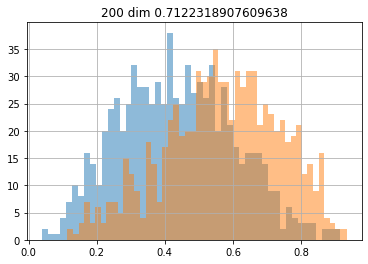

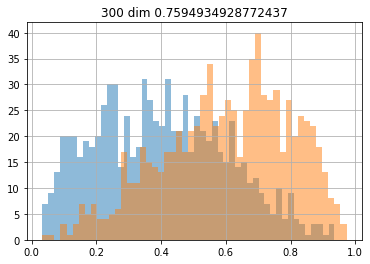

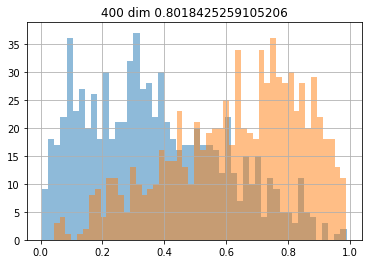

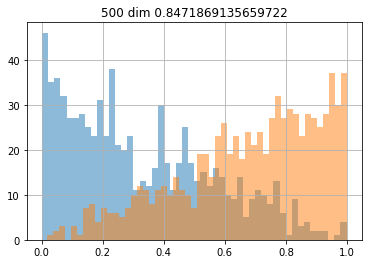

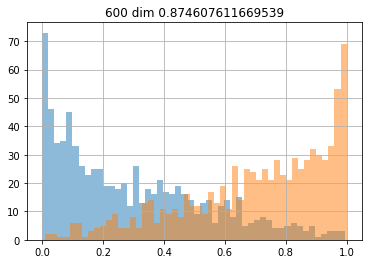

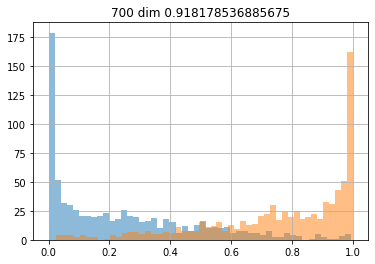

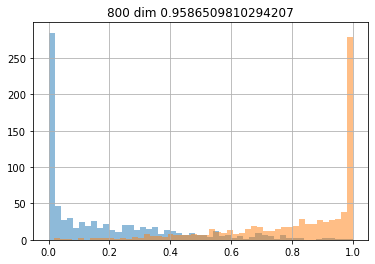

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


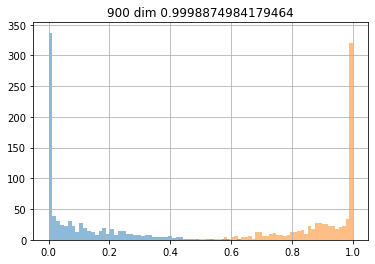

In [6]:
for n_used_vars in list(range(10, 100, 10)) + list(range(100, 1000, 100)):
    model = LogisticRegression()
    model.fit(X_train.iloc[:, :n_used_vars], y_train)
    y_pred = model.predict_proba(X_train.iloc[:, :n_used_vars])[:, 1]
    auc = roc_auc_score(y_train, y_pred)

    plot_df = pd.DataFrame(y_pred, columns=['y_pred'])
    plot_df['label'] = y_train.tolist()

    plot_df.loc[plot_df['label'] == 0, 'y_pred'].hist(bins=50, alpha=0.5)
    plot_df.loc[plot_df['label'] == 1, 'y_pred'].hist(bins=50, alpha=0.5)
    plt.title(f'{n_used_vars} dim {auc}')
    
    plt.show()

Egyre több zajjal rátanul a random zajra a tanító adathalmazon, viszont a teszten láthatóan nem materializálódik a tudás:

In [7]:
y_pred = model.predict_proba(X_test.iloc[:, :n_used_vars])[:, 1]
roc_auc_score(y_test, y_pred)

0.5301442824635543

### F2 -  Mi lenne ha - a lehetséges kombinációk számának megértése / megérzése
Tegyük fel hogy:
- Egy tanítási és tesztelési, kiértékelési ciklus 10ms alatt lefut
- Rendelkezésünkre áll Magyarország összes számítógépe, mondjuk 10 millió számítógép 
- A 64 elemű változólistából minden kombinációt ki akarunk próbálni, kivéve azt, amikor az összes elemet kizárjuk a bemeneti változók közül.

__KÉRDÉS__: Mennyi ideig tartana kipróbálni az összes lehetséges kombinációt ennyi gépen?

In [8]:
2 ** 64 * 10 / 10_000_000 / 1000 / 60 / 60 / 24 / 365

584.9424173550719

## F3 - változókiválasztási módszerek összevetéséhez summary baseline-nal

In [9]:
from sklearn.datasets import load_digits

digits=load_digits(as_frame=True)
X = digits.data
y = digits.target

y = y == 3

In [10]:
from sklearn.metrics import log_loss, roc_auc_score

In [11]:
def add_to_summary(summary, X_train, X_test, y_train, y_test, method, model):
    model.fit(X_train, y_train)

    summary.loc[method, 'Logloss - train'] = log_loss(y_train, model.predict_proba(X_train))
    summary.loc[method, 'Logloss - test'] = log_loss(y_test, model.predict_proba(X_test))
    summary.loc[method, 'n_features'] = len(X_train.columns)
    summary.loc[method, 'features'] = list(X_train.columns)
    print(summary.loc[method])

    return summary, model

summary = pd.DataFrame(columns=['Logloss - train', 'Logloss - test', 'n_features', 'features'])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [13]:
model = LogisticRegression(max_iter=1000, random_state=42)

In [14]:
summary, model = add_to_summary(summary, X_train, X_test, y_train, y_test, method='baseline', model=model)

Logloss - train                                             0.005157
Logloss - test                                               0.10543
n_features                                                        64
features           [pixel_0_0, pixel_0_1, pixel_0_2, pixel_0_3, p...
Name: baseline, dtype: object


## F4 - Korreláció alapú szelekció

In [15]:
from tqdm import tqdm
from sklearn.model_selection import cross_val_predict

In [16]:
X_train_w_label = X_train.join(y_train)
ordered_by_corr = list(abs(X_train_w_label.corr()['target']).sort_values(ascending=False).drop('target').index)
del X_train_w_label

In [17]:
topX_corr_perf = {}

for i in tqdm(range(1, len(ordered_by_corr))):
    selected_vars = ordered_by_corr[:i]
    y_pred = cross_val_predict(model, X_train[selected_vars], y_train, cv=4, method='predict_proba')[:, 1]
    topX_corr_perf[i] = log_loss(y_train, y_pred)

100%|██████████| 63/63 [00:33<00:00,  1.87it/s]


<AxesSubplot:>

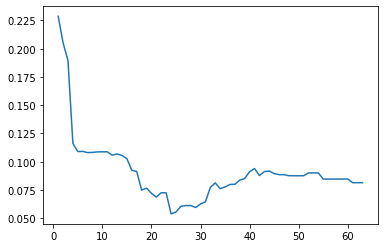

In [18]:
pd.Series(topX_corr_perf).plot()

Egy bizonyos számú változó felvétele után már romlik a teljesítmény, a legjobb itt:

In [19]:
min_loss_idx = pd.Series(topX_corr_perf).idxmin()
min_loss_idx

24

In [20]:
vars_selected_by_corr_method = ordered_by_corr[:min_loss_idx]

In [21]:
summary, trained_model = add_to_summary(summary, X_train[vars_selected_by_corr_method], X_test[vars_selected_by_corr_method], y_train, y_test, method='top-corr', model=model)

Logloss - train                                             0.029872
Logloss - test                                              0.058009
n_features                                                        24
features           [pixel_3_2, pixel_4_2, pixel_2_2, pixel_5_3, p...
Name: top-corr, dtype: object


## F5 - Forward selection módszere

Változókról egyesével megnézzük, és azt vesszük be, aki a legjobban csökkenti a loss-t.

### A) ELSŐ ESET: Manual

In [ ]:
unchosen_vars = X_train.columns.tolist()
chosen_vars = []
best_logloss = 999

for i in tqdm(range(64)):
#    print(f'----- iteration {i} -----')
    winner = None
    for contender in unchosen_vars:
        y_pred = cross_val_predict(model, X_train[chosen_vars + [contender]], y_train, cv=4, method='predict_proba')[:, 1]
        contender_perf = log_loss(y_train, y_pred)
        if contender_perf < best_logloss:
#            print(f'winner: {contender} logloss = {contender_perf}')
            winner = contender
            winner_perf = contender_perf
            best_logloss = contender_perf

    if winner:
        unchosen_vars.remove(winner)
        chosen_vars.append(winner)
        best_logloss = winner_perf
    else:
        print('no var improves logloss')
        break

 38%|███▊      | 24/64 [03:45<11:00, 16.52s/it]

In [23]:
summary, trained_model = add_to_summary(summary, X_train[chosen_vars], X_test[chosen_vars], y_train, y_test, method='manual-Forward', model=model)

Logloss - train                                             0.027264
Logloss - test                                              0.080165
n_features                                                        48
features           [pixel_7_7, pixel_7_5, pixel_7_6, pixel_7_4, p...
Name: manual-Forward, dtype: object


### B) SequentialFeatureSelector fixált n_feature esetén

In [24]:
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SequentialFeatureSelector

In [25]:
my_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

In [26]:
sfs = SequentialFeatureSelector(model, n_features_to_select=24, cv=4, scoring=my_scorer)

In [27]:
sfs.fit(X_train, y_train)

SequentialFeatureSelector(cv=4,
                          estimator=LogisticRegression(max_iter=1000,
                                                       random_state=42),
                          n_features_to_select=24,
                          scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True))

In [28]:
selected_by_sfs = list(X_train.columns[sfs.get_support()])

In [29]:
summary, trained_model = add_to_summary(summary, X_train[selected_by_sfs], X_test[selected_by_sfs], y_train, y_test, method='forward_fix24', model=model)

Logloss - train                                             0.014869
Logloss - test                                              0.061972
n_features                                                        24
features           [pixel_0_4, pixel_0_6, pixel_1_4, pixel_1_5, p...
Name: forward_fix24, dtype: object


A kézihez képest egy változót választott másnak:

In [30]:
set(selected_by_sfs) - set(chosen_vars)

{'pixel_0_4',
 'pixel_0_6',
 'pixel_1_4',
 'pixel_1_6',
 'pixel_2_2',
 'pixel_2_3',
 'pixel_6_7'}

## C) SequentialFeatureSelector auto n_feature esetén

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

In [ ]:
summary, trained_model = add_to_summary(summary, X_train[], X_test[], y_train, y_test, method='forward_sfs', model=model)

## F6 - Recursive feature elimination (RFE)

In [31]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [32]:
my_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

In [33]:
rfe = RFECV(model, cv=4, scoring=my_scorer)

In [34]:
rfe.fit(X_train, y_train)

RFECV(cv=4, estimator=LogisticRegression(max_iter=1000, random_state=42),
      scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True))

In [35]:
cols_by_rfe = X_train.columns[rfe.get_support()]

<AxesSubplot:>

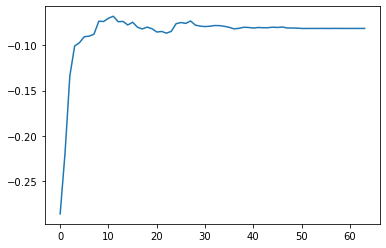

In [36]:
pd.Series(rfe.cv_results_['mean_test_score']).plot()

In [37]:
pd.Series(rfe.cv_results_['mean_test_score']).idxmax()

11

10
12
27
34


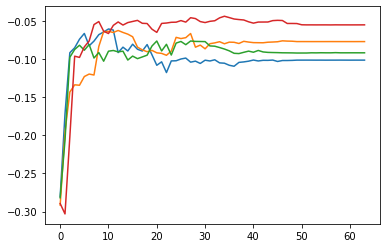

In [38]:
for i in range(4):
    s = pd.Series(rfe.cv_results_[f'split{i}_test_score'])
    print(s.idxmax())
    s.plot()

In [39]:
summary, trained_model = add_to_summary(summary, X_train[cols_by_rfe], X_test[cols_by_rfe], y_train, y_test, method='RFE', model=model)

Logloss - train                                             0.026976
Logloss - test                                              0.081643
n_features                                                        12
features           [pixel_0_4, pixel_1_4, pixel_1_6, pixel_2_2, p...
Name: RFE, dtype: object


## F7 - Model alapú megoldások - Logisztikus regresszió coeficiennsei 

In [25]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [32]:
ordered_by_coef = list(abs(pd.Series(model.coef_[0], index=X_train.columns)).sort_values(ascending=False).index)

In [33]:
topX_perf = {}

for i in tqdm(range(1, len(ordered_by_coef))):
    selected_vars = ordered_by_coef[:i]
    y_pred = cross_val_predict(model, X_train[selected_vars], y_train, cv=4, method='predict_proba')[:, 1]
    topX_perf[i] = log_loss(y_train, y_pred)

100%|██████████| 63/63 [00:29<00:00,  2.10it/s]


<AxesSubplot:>

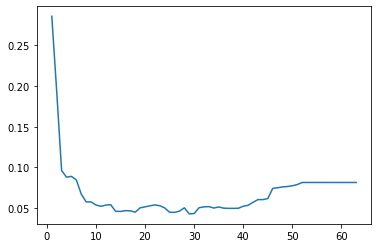

In [34]:
pd.Series(topX_perf).plot()

In [35]:
min_loss_idx = pd.Series(topX_perf).idxmin()
min_loss_idx

29

In [45]:
cols_by_linreg = ordered_by_coef[:min_loss_idx]

In [46]:
summary, trained_model = add_to_summary(summary, X_train[cols_by_linreg], X_test[cols_by_linreg], y_train, y_test, method=f'model_based_logreg', model=model)

Logloss - train                                             0.007581
Logloss - test                                              0.129943
n_features                                                        63
features           [pixel_1_6, pixel_1_2, pixel_0_4, pixel_6_6, p...
Name: model_based_logreg, dtype: object


## F8 - Változó kiválasztás lasso regresszió segítségével

$ célfüggvény = ModellHibájaAPontokon + \frac{1}{C}*ModellKomplexitás = ModellHibájaAPontokon + \frac{1}{C} * \sum_{i=1}^{m}|\alpha_i|$

In [47]:
Cs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 5, 10, 25, 50, 100]

In [48]:
logloss_df = pd.DataFrame()
for C in tqdm(Cs):
    model_for_lasso = LogisticRegression(solver='saga', max_iter=1000, penalty='l1', C=C, random_state=42)
    pred_proba = cross_val_predict(model_for_lasso, X_train, y_train, cv=4, method='predict_proba')[:,1]
    logloss_df.loc[C, 'Logloss'] = log_loss(y_train, pred_proba)

    model_for_lasso.fit(X_train, y_train)
    selected_vars = list(X_train.columns[model_for_lasso.coef_[0]!=0])
    logloss_df.loc[C, 'selected_vars'] = [[selected_vars]]
    logloss_df.loc[C, 'n_selected_vars'] = len(selected_vars)

 15%|█▌        | 2/13 [00:12<01:10,  6.45s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 23%|██▎       | 3/13 [00:22<01:22,  8.21s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages

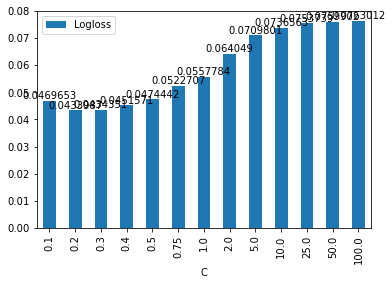

In [49]:
ax = logloss_df.reset_index().rename(columns = {'index':'C'}).plot.bar(x='C', y='Logloss')
ax.bar_label(ax.containers[0]);

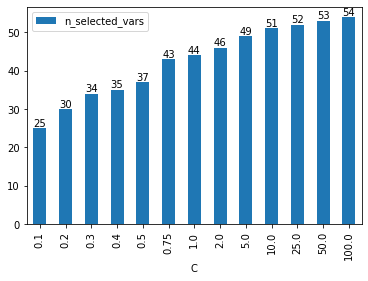

In [50]:
ax = logloss_df.reset_index().rename(columns = {'index':'C'}).plot.bar(x='C', y='n_selected_vars')
ax.bar_label(ax.containers[0]);

In [51]:
best_C = logloss_df['Logloss'].idxmin()
print(f'Best C is {best_C}')

selected_vars_for_best_C = logloss_df.loc[best_C, 'selected_vars']
selected_by_lasso = selected_vars_for_best_C[0]

model = LogisticRegression(max_iter=1000, random_state=42)

Best C is 0.2


In [52]:
summary, model_trained = add_to_summary(summary, X_train[selected_by_lasso], X_test[selected_by_lasso], y_train, y_test, method=f'lasso', model=model)

Logloss - train                                             0.007039
Logloss - test                                              0.099027
n_features                                                        30
features           [pixel_0_2, pixel_0_3, pixel_0_4, pixel_1_1, p...
Name: lasso, dtype: object



## F9 - model_based (gbm + feature_importance)

In [53]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier(n_estimators=600, max_depth=3, random_state=42, learning_rate=0.1)
summary, trained_model = add_to_summary(summary, X_train, X_test, y_train, y_test, method = 'gbm_bl', model=gbm)
var_imps = pd.Series(trained_model.feature_importances_, index=X_train.columns)
n_of_vars_with_zero_importance = (var_imps==0).sum()
print(f'\nn features with zero importance = {n_of_vars_with_zero_importance}')

Logloss - train                                                  0.0
Logloss - test                                              0.066845
n_features                                                        64
features           [pixel_0_0, pixel_0_1, pixel_0_2, pixel_0_3, p...
Name: gbm_bl, dtype: object

n features with zero importance = 14


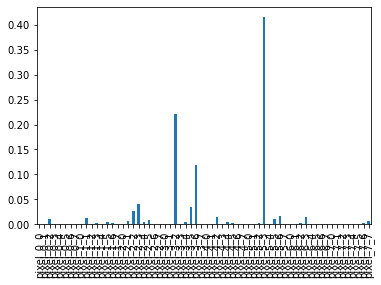

In [54]:
var_imps = pd.Series(trained_model.feature_importances_, index=X_train.columns)
var_imps.plot.bar()
plt.rcParams["figure.figsize"] = (20,10)

100%|██████████| 64/64 [09:19<00:00,  8.74s/it]


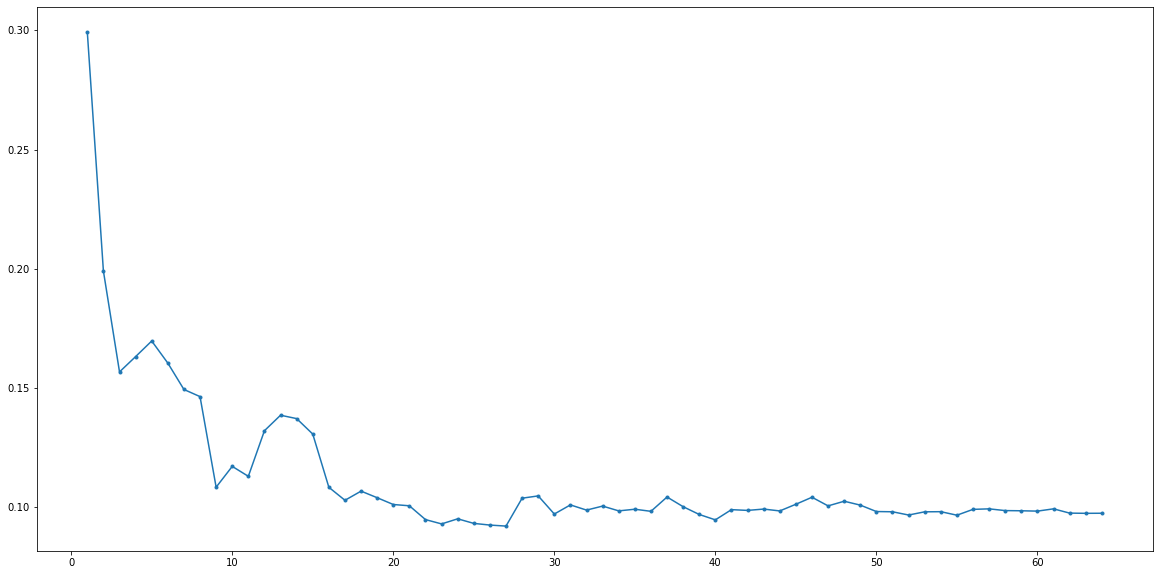

In [55]:
imp_based_topX = pd.DataFrame()
vars_sorted_by_imp = list(var_imps.sort_values(ascending=False).index)
for top_x in tqdm(range(1, len(vars_sorted_by_imp)+1)):
    selected_vars = vars_sorted_by_imp[:top_x]
    pred_proba = cross_val_predict(gbm, X_train[selected_vars], y_train, cv=4, method='predict_proba')[:,1]
    imp_based_topX.loc[top_x, 'Logloss'] = log_loss(y_train, pred_proba)

imp_based_topX['Logloss'].plot(marker='.')

best_n_features = imp_based_topX['Logloss'].idxmin()
selected_vars = vars_sorted_by_imp[:best_n_features]

In [57]:
summary, trained_model = add_to_summary(summary, X_train[selected_vars], X_test[selected_vars], y_train, y_test, method=f'model_based_gbm', model=model)

Logloss - train                                             0.020563
Logloss - test                                               0.05667
n_features                                                        27
features           [pixel_5_3, pixel_3_2, pixel_3_6, pixel_2_3, p...
Name: model_based_gbm, dtype: object


## F10 - melyik pixelt választják ki legtöbbször a különböző módszerek?

In [58]:
methods = ['top-corr', 'manual-Forward', 'RFE', 'model_based_logreg', 'model_based_gbm', 'lasso']
selected_vars_all = summary.loc[methods, 'features'].tolist()
falttened_selected_vars_all = [selected_feature for selected_features in selected_vars_all for selected_feature in selected_features]

In [59]:
selected_times={}
for pixel in X_train.columns:
    selected_times[pixel]=0

In [60]:
for used_pixel in falttened_selected_vars_all:
    selected_times[used_pixel]=selected_times[used_pixel]+1

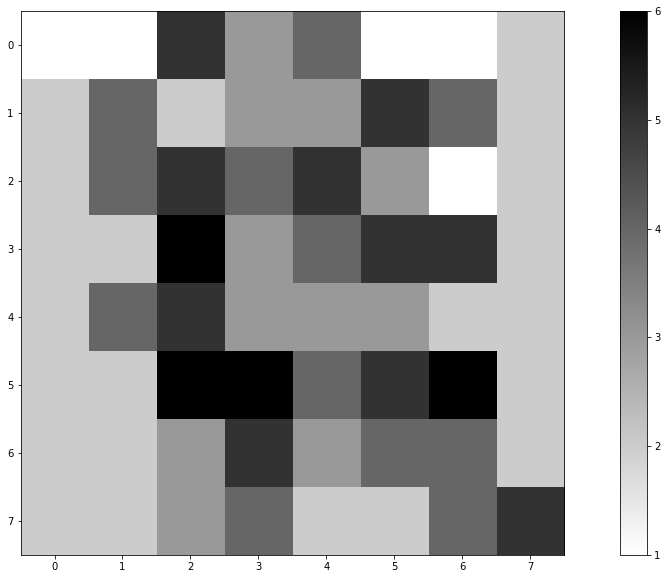

In [61]:
plt.imshow(np.array(list(selected_times.values())).reshape(8, 8), cmap='gray_r')
plt.colorbar()

In [62]:
[i for i in selected_times.values() if i == 6]

[6, 6, 6, 6]

## Konklúzió - vizualizáljuk az egyes módszerekkel kiválasztott pixelek milyen súllyal kerülnek be a modellbe

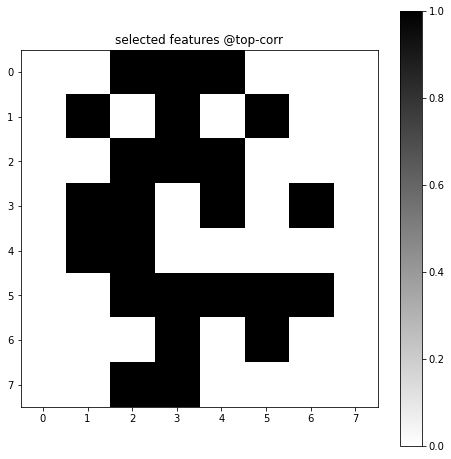

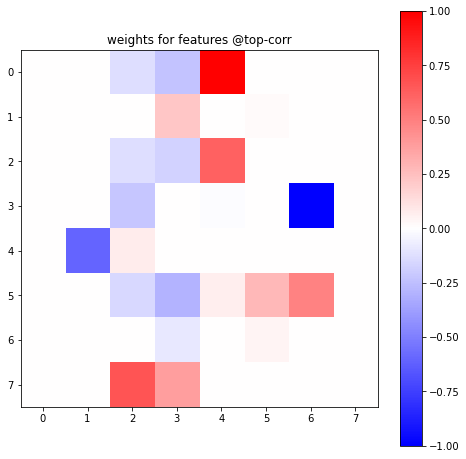

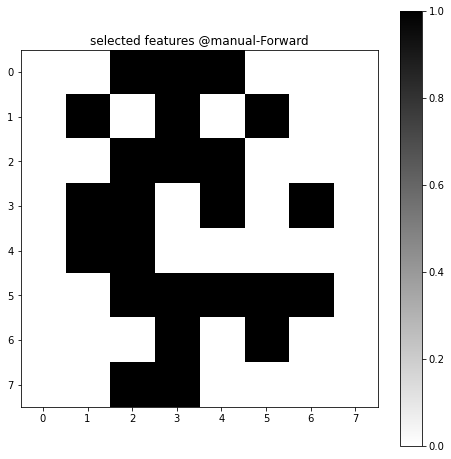

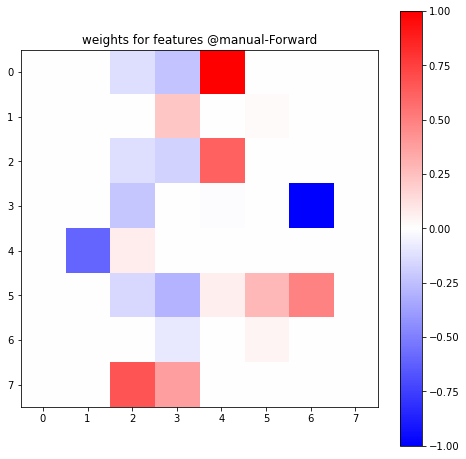

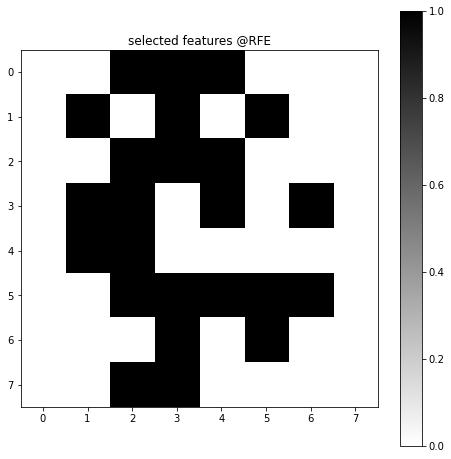

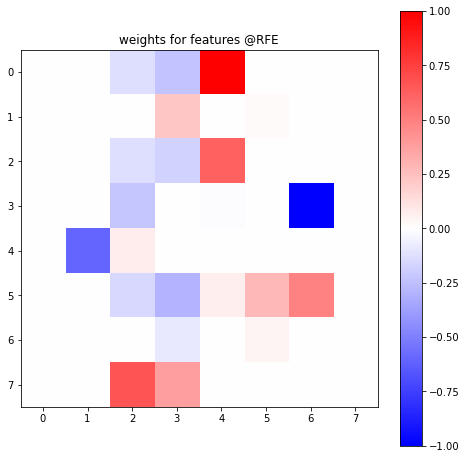

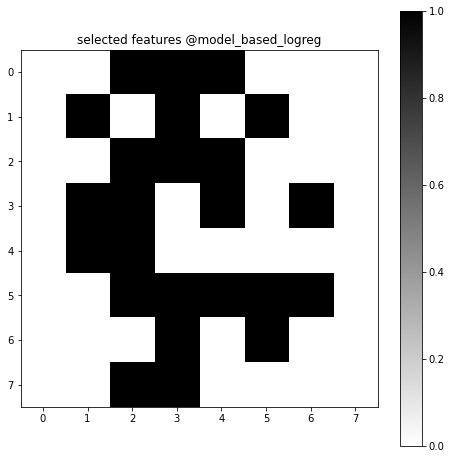

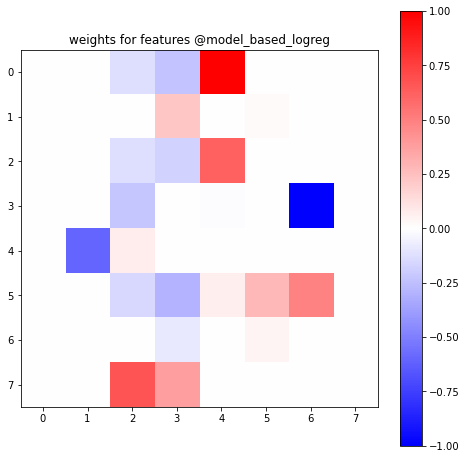

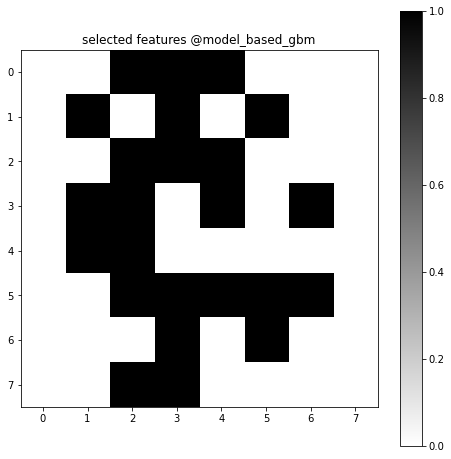

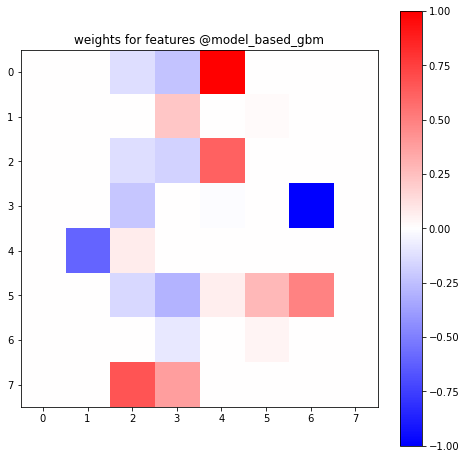

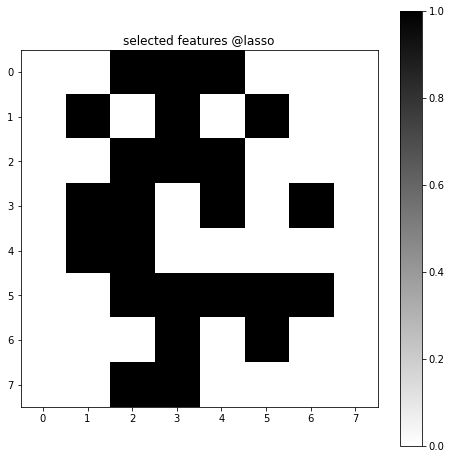

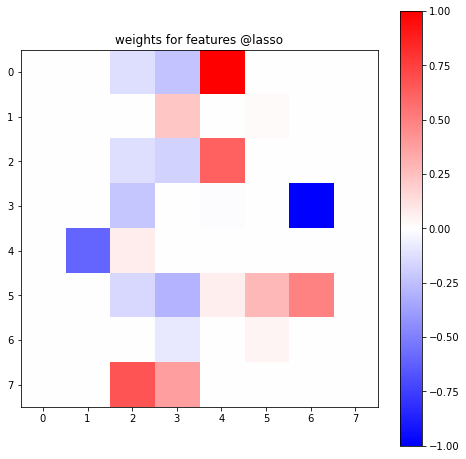

In [63]:
def scale01(s):
        return (s-s.min())/(s.max()-s.min())

for method in methods:
    selected_vars_with_method = summary.loc[methods[0], "features"]
    plt.figure(figsize=(8,8))
    vars64 = np.array([1 if str(item) in selected_vars_with_method else 0 for item in X_train.columns])
    plt.imshow(vars64.reshape(8, 8), cmap='gray_r', vmin=0, vmax=1)
    plt.title(f'selected features @{method}')
    plt.colorbar()
    plt.show()

    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train[selected_vars_with_method], y_train)
    all_pixels_weights = pd.DataFrame(index=X_train.columns)
    all_pixels_weights = all_pixels_weights.join(pd.DataFrame(model.coef_[0], index=selected_vars_with_method))
    all_pixels_weights = all_pixels_weights.fillna(0)

    negative_coefs = all_pixels_weights.loc[all_pixels_weights[0]<0]
    scaled_negatives_to_minus1_0 = scale01(negative_coefs)-1
    positive_coefs = all_pixels_weights.loc[all_pixels_weights[0]>0]
    scaled_positives_to_0_1 = scale01(positive_coefs)
    all_pixels_weights['scaled'] = pd.concat([scaled_negatives_to_minus1_0, scaled_positives_to_0_1])
    all_pixels_weights['scaled'] = all_pixels_weights['scaled'].fillna(0)

    all_pixels_weights_array = np.array(all_pixels_weights['scaled'].tolist())
    plt.figure(figsize=(8,8))
    plt.imshow(all_pixels_weights_array.reshape(8, 8), cmap='bwr')
    plt.colorbar()
    plt.title(f'weights for features @{method}')
    plt.show()